## MLP NN

A simple mlp nn to deblur signals.

The model a standard form seen repeatedly in online tutorials.

Functions are then defined to create training and testing data from the initial training data generated. 

It is then run showing low values of loss. 

In [66]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# # This is the MLP model which we initially used but later replaced with CNN
# # Building the model

# class DeblurMLP(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(DeblurMLP, self).__init__()
        
#         self.model = nn.Sequential(
#             nn.Linear(input_size, hidden_size1),
#             nn.ReLU(),
#             nn.Linear(hidden_size1, hidden_size2),
#             nn.ReLU(),
#             nn.Linear(hidden_size2, output_size)
#         )
        
#     def forward(self, x):
#         return self.model(x)


# # Example usage

# input_size = 500 
# hidden_size1 = 256
# hidden_size2 = 128
# output_size = 500
# model = DeblurMLP(input_size, hidden_size1, hidden_size2, output_size)

# print(model)

DeblurMLP(
  (model): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=500, bias=True)
  )
)


In [ ]:
# the CNN model for better debulurring performance
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 1, kernel_size=7, padding=3),
        )
    
    def forward(self, x):
        # x shape: (batch_size, signal_length)
        x = x.unsqueeze(1)  
        x = self.encoder(x)
        x = self.decoder(x)
        return x.squeeze(1)  

In [ ]:
# Preparing the training data into training and testing segments

def prepre_train_test_data(training_data, test_size, seed=42):

    blur_cols = [col for col in training_data.columns if 'y_blur' in col]
    clean_cols = [col for col in training_data.columns if 'y_clean' in col]

    blur_cols.sort(key=lambda x: int(x.split('_')[-1]))
    clean_cols.sort(key=lambda x: int(x.split('_')[-1]))

    X = training_data[blur_cols].values.T
    y = training_data[clean_cols].values.T

    # split_idx = int((1 - test_size) * len(X))
    
    # X_train = X[:split_idx]
    # y_train = y[:split_idx]
    # X_test = X[split_idx:]
    # y_test = y[split_idx:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    return X_train, X_test, y_train, y_test


In [89]:
# training the model and calculating loss

def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, batch_size=32, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

    train_losses = []
    test_losses = []
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)

        avg_train_loss = epoch_loss / len(X_train)
        train_losses.append(avg_train_loss)
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
            test_losses.append(test_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses



In [90]:
# visualising the loss 

def visualise_training(train_losses, test_losses):

    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.yscale('log')
    plt.title('Training and Test Loss Over Time', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
    print(f"Final Test Loss: {test_losses[-1]:.6f}")


Epoch [10/10], Train Loss: 0.0001, Test Loss: 0.0001


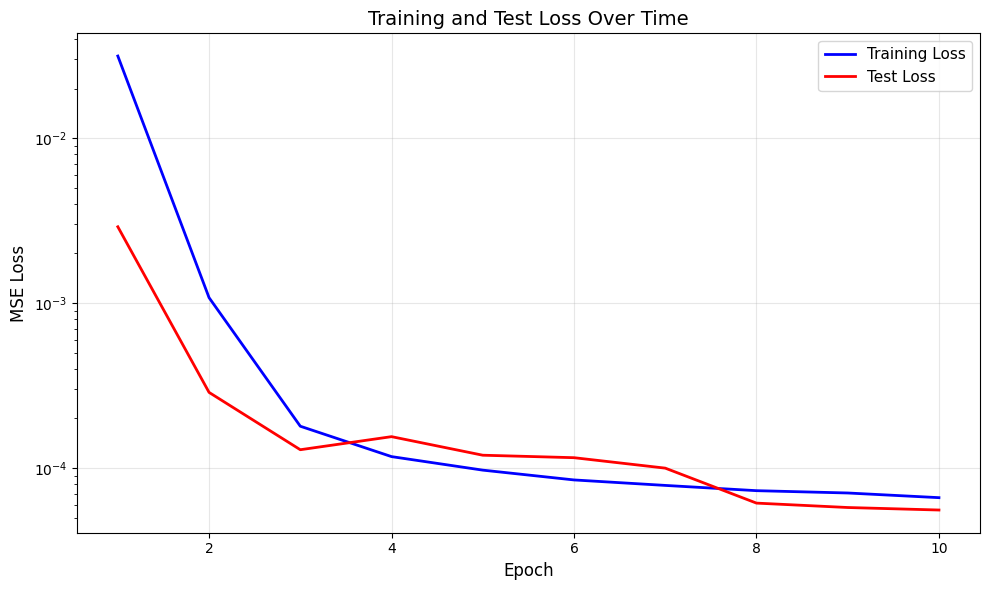


Final Training Loss: 0.000066
Final Test Loss: 0.000056


In [95]:
# Running the full process

filepath = "C:\\Users\\Jpjha\\OneDrive\\Desktop\\Decon by ML\\Code\\training_data.pkl"
training_data = pd.read_pickle(filepath)

X_train, X_test, y_train, y_test = prepre_train_test_data(training_data, test_size=0.2, seed=42)

# model = DeblurMLP(input_size=500, hidden_size1=256, hidden_size2=128, output_size=500)

model = DeblurCNN()

train_losses, test_losses = train_model(model=model,X_train=X_train,y_train=y_train, X_test=X_test,
                                         y_test=y_test, epochs=10, batch_size=32, lr=0.001)

visualise_training(train_losses, test_losses)

torch.save(model.state_dict(), 'deblur_model.pth')

In [ ]:
def validate_and_visualise(model, validation_data):

    blur_cols = [col for col in validation_data.columns if 'y_blur' in col]
    clean_cols = [col for col in validation_data.columns if 'y_clean' in col]

    blur_cols.sort(key=lambda x: int(x.split('_')[-1]))
    clean_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
    # Extract the actual DATA from these columns (not just the names)
    blur_data = validation_data[blur_cols].values.T  # Transpose so each row is a signal
    clean_data = validation_data[clean_cols].values.T
    
    # Convert to tensors
    blur_tensors = torch.FloatTensor(blur_data)
    clean_tensors = torch.FloatTensor(clean_data)
    
    # Run through model
    with torch.no_grad():
        deblurred_signals = model(blur_tensors)
    
    # Convert to numpy for plotting
    blurred_np = blur_tensors.numpy()
    clean_np = clean_tensors.numpy()
    deblurred_np = deblurred_signals.numpy()
    
    # Calculate metrics for each signal
    mse_values = []
    for i in range(len(deblurred_np)):
        mse = np.mean((deblurred_np[i] - clean_np[i]) ** 2)
        mse_values.append(mse)
    
    # Create figure with subplots (2 columns, 5 rows for 8 signals)
    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    axes = axes.flatten()
    
    for i in range(8):
        ax = axes[i]
        
        # Plot all three signals
        ax.plot(validation_data['x'], clean_np[i], 'g-', label='Clean (Ground Truth)', 
                linewidth=2, alpha=0.8)
        ax.plot(validation_data['x'], blurred_np[i], 'r--', label='Blurred + Noisy', 
                linewidth=1.5, alpha=0.7)
        ax.plot(validation_data['x'], deblurred_np[i], 'b-', label='Deblurred (Model)', 
                linewidth=2, alpha=0.8)
        
        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('Signal Value', fontsize=10)
        ax.set_title(f'Validation Signal {i+1} (MSE: {mse_values[i]:.6f})', fontsize=11)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    plt.show()
    
   
    return deblurred_np, mse_values






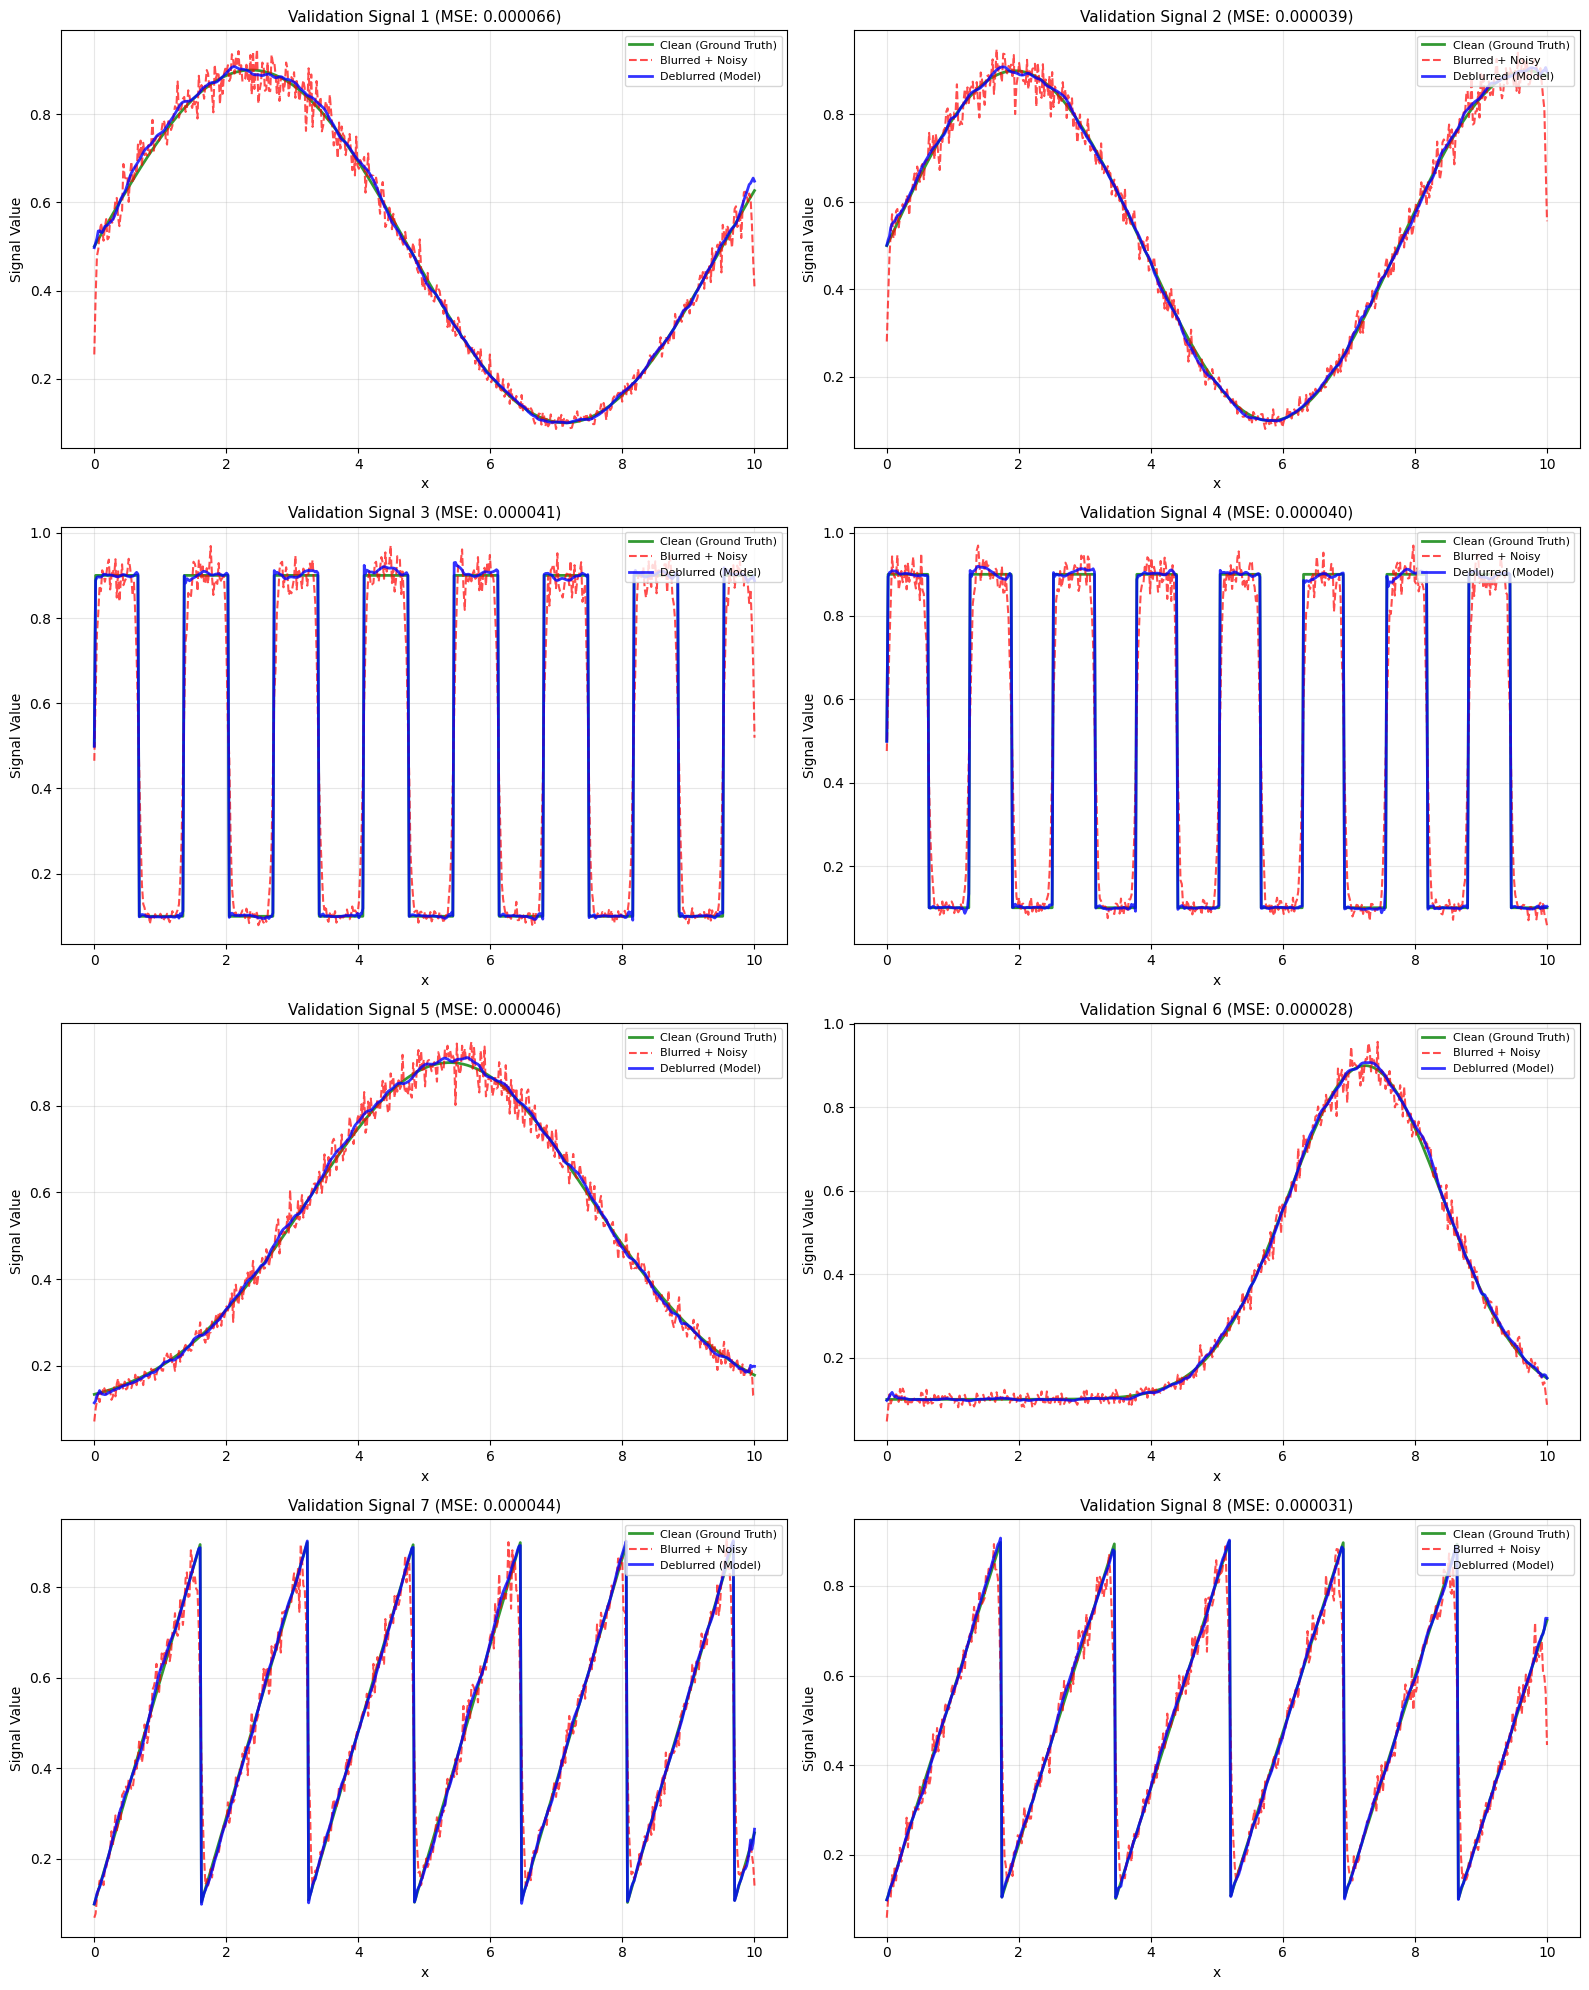

(array([[0.49717972, 0.50803137, 0.51859313, ..., 0.6489398 , 0.65499926,
         0.6479519 ],
        [0.5011314 , 0.51320606, 0.52165645, ..., 0.9006654 , 0.90751004,
         0.89766765],
        [0.49890682, 0.8883334 , 0.89531595, ..., 0.8934259 , 0.8997707 ,
         0.8875789 ],
        ...,
        [0.09754241, 0.10092764, 0.10660982, ..., 0.15938424, 0.15765111,
         0.15107197],
        [0.10047151, 0.11099781, 0.12360303, ..., 0.2209349 , 0.2350346 ,
         0.2656739 ],
        [0.0998362 , 0.10751085, 0.12034221, ..., 0.70416117, 0.72785604,
         0.72739106]], shape=(8, 500), dtype=float32),
 [np.float32(6.609358e-05),
  np.float32(3.8812654e-05),
  np.float32(4.0936273e-05),
  np.float32(4.0424562e-05),
  np.float32(4.6273424e-05),
  np.float32(2.788325e-05),
  np.float32(4.3758395e-05),
  np.float32(3.1205695e-05)])

In [97]:
vlaidation_data = pd.read_pickle("C:\\Users\\Jpjha\\OneDrive\\Desktop\\Decon by ML\\Code\\validation_data.pkl")
validate_and_visualise(model, vlaidation_data)